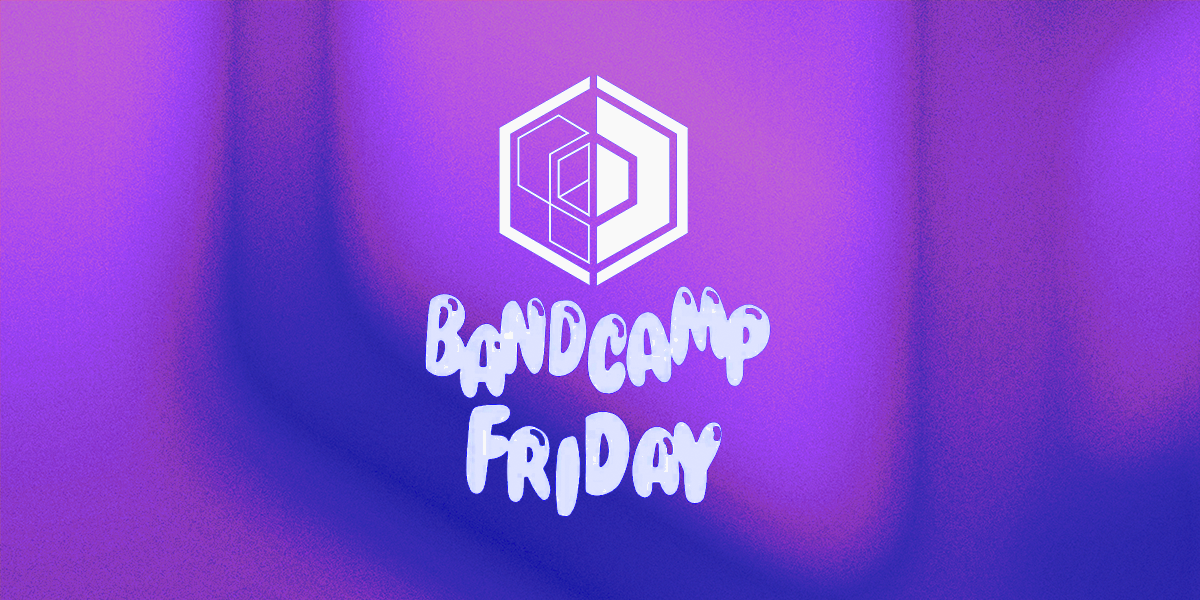

<center> <h1> Bandcamp Friday began in March 2020 as a way to help artists recoup lost revenue during the Covid-19 pandemic.</h1>
    <br> <h3> On this one-day promotion, Bandcamp waived their fees and passed all revenue directly on to the artists.  The initial Bandcamp Friday was so successful, Bandcamp extended the promotion to include the first Friday of each month until May 2021.  As of May 6th, 2021, Bandcamp Friday has been extended well into 2021.</h3>
    <br><br> In this report, I seek to pull Twitter data and analyze it in an attempt to determine how releasing an album on Bandcamp Friday might change the Twitter conversation around an artist.  To do this, I've located two incredibly obscure,  niche bands, as well as two more moderately well-known musicians with more accessable music, all 4 of which released new music on Bandcamp Friday (May 7, 2021).  <br><br>The report will consist of pulling all Tweets mentioning each artist beginning on the Monday before Bandcamp Friday (5 days before the release of the new album) and ending on Sunday May 9th (2 days after release).  With this data collected, I can compare number of Tweets for each artist before and after the release, as well as analyze the sentiment of Tweets around each artist.  <br><br>In this way, I hope to determine whether niche artists or more well-known ones receive a bigger "bump" in awareness or higher positive sentiment from releasing an album on Bandcamp Friday.

<h6> The first step is to identify which artists I'd like to compare.  I am considering the following:</h6>
<br>
<ul>
    <li>The 2 obscure artists should have a similar number of Twitter followers to one another.</li>
    <li>Similarly, the 2 more well-known artists should have a similar number of Twitter followers to one another.</li>
    <li>The name of each artist should be unique enough so as to avoid "noise" in the searches.</li>

With my artists in mind, I can begin coding.

###### Import needed libraries and Twitter authorization token.

In [269]:
import requests
import numpy as np
import urllib
import json
import pandas as pd
import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
from matplotlib import pyplot as plt
from datetime import datetime as dt
import seaborn
import matplotlib.patches as mpatches

In [3]:
tokens = pd.read_csv(r'C:\Users\waxen\Desktop\TWITTER API KEYS.txt', sep = '\t', header = None).T
tokens.columns = tokens.iloc[0]
tokens = tokens[1:]
#tokens.Bearer_Token[1]

In [5]:
def auth():
    return tokens.Bearer_Token[1]

#print(auth())

###### The first artist is Portuguese post-punk band IAMTHESHADOW.

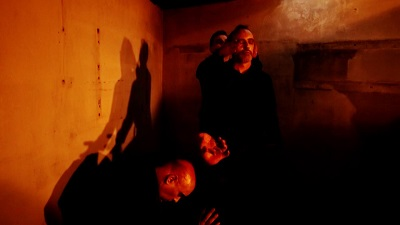

###### IAMTHESHADOW has 108 Twitter followers and released a full-length album "Everything in this Nothingness" on May 7.

###### Create the URL and query strings to search for recent mentions of IAMTHESHADOW.

In [210]:
def create_shadow_url():
    query = urllib.parse.quote('("iamtheshadow") OR @IAMTHESHADOW17')
    tweet_fields = 'tweet.fields=author_id,public_metrics,id,text,created_at'
    url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
    return url

print(create_shadow_url())

https://api.twitter.com/2/tweets/search/recent?query=%28%22iamtheshadow%22%29%20OR%20%40IAMTHESHADOW17&tweet.fields=author_id,public_metrics,id,text,created_at


In [211]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

#print(create_headers(tokens.Bearer_Token[1]))

In [212]:
def connect_to_endpoint(url, headers):
    response = requests.request("GET", url, headers=headers)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [213]:
def main():
    bearer_token = auth()
    url = create_shadow_url()
    headers = create_headers(bearer_token)
    json_response = connect_to_endpoint(url, headers)
    #print(json.dumps(json_response, indent=4, sort_keys=True))
    return json_response

###### Display the results to examine and ensure everthing looks correct.

In [214]:
main()

200


{'data': [{'id': '1391463510106902536',
   'author_id': '59925530',
   'public_metrics': {'retweet_count': 0,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'text': 'NOW PLAYING: On Winter Leaves Embrace by IAMTHESHADOW - Listen live on the free iPhone &amp; Android apps and at https://t.co/KlMNLOhSAo. https://t.co/vDWQX2xy27',
   'created_at': '2021-05-09T18:42:07.000Z'},
  {'id': '1391340051502612485',
   'author_id': '75987352',
   'public_metrics': {'retweet_count': 0,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'text': '#NowPlaying  IAMTHESHADOW - Tongueless  \n#webradio #onair\nlisten now for free:\nhttps://t.co/VpFwBRdchf',
   'created_at': '2021-05-09T10:31:32.000Z'},
  {'id': '1391197697843994624',
   'author_id': '1483417808',
   'public_metrics': {'retweet_count': 1,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'text': 'RT @xmontesvictorx: https://t.co/g5b2tLxNpI #postpunk #darkwave #synthpop #coldwave ho

In [215]:
shadow_data = main()

200


###### Explore the data structure so I can manipulate the data as needed.

In [216]:
shadow_data.keys()

dict_keys(['data', 'meta'])

In [217]:
shadow_data['data'][2]

{'public_metrics': {'retweet_count': 1,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'author_id': '1483417808',
 'text': 'RT @xmontesvictorx: https://t.co/g5b2tLxNpI #postpunk #darkwave #synthpop #coldwave hosted by @deftkantian &amp; co-curator @xmontesvictorx ft.…',
 'created_at': '2021-05-09T01:05:53.000Z',
 'id': '1391197697843994624'}

In [218]:
shadow_data['meta']

{'newest_id': '1391463510106902536',
 'oldest_id': '1390580247658127360',
 'result_count': 10,
 'next_token': 'b26v89c19zqg8o3foswqkc8y5j1xdvzk5w2zo0vydy4jh'}

###### There's a "next token", so I'll need to set up pagination to see more results.

In [219]:
def create_url_pag(next_token = None):
    query = urllib.parse.quote('("iamtheshadow") OR @IAMTHESHADOW17')
    tweet_fields = 'tweet.fields=author_id,public_metrics,id,text,created_at'
    if (next_token):        
        pagination = next_token
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&next_token={}&{}'.format(query, pagination, tweet_fields)
        return url
    else:
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
        return url
    
print(create_url_pag(None))
print(create_url_pag('000000000000000'))

https://api.twitter.com/2/tweets/search/recent?query=%28%22iamtheshadow%22%29%20OR%20%40IAMTHESHADOW17&tweet.fields=author_id,public_metrics,id,text,created_at
https://api.twitter.com/2/tweets/search/recent?query=%28%22iamtheshadow%22%29%20OR%20%40IAMTHESHADOW17&next_token=000000000000000&tweet.fields=author_id,public_metrics,id,text,created_at


In [220]:
def shadow_pages():
    count = 0
    next_token = None
    dat = pd.DataFrame()
    while (count < 2):
        bearer_token = auth()
        url = create_url_pag(next_token)        
        headers = create_headers(bearer_token)
        json_response = connect_to_endpoint(url, headers)        
        next_token = json_response['meta']['next_token']
        dat = dat.append(pd.DataFrame(json_response['data']), ignore_index = True)        
        count = count + 1
    return dat

In [221]:
shadow_pages = shadow_pages()

200
200


In [222]:
#shadow_pages

###### With data from each page collected into one structure, VADER sentiment analysis can begin.

In [223]:
analyser = SentimentIntensityAnalyzer()
warnings.filterwarnings('ignore')

In [224]:
print(shadow_pages['text'][12])
print(analyser.polarity_scores(shadow_pages['text'][12]))

#MetropolisMWR SOTN Top Ten
All The Damn Vampires and Yota
SYNTRONIX feat Chris KD
Teleman
Scandroid feat King Protea
Betamaxx
Futurecop! and DWNTWN
Roxi Drive and Voynich
Michael Kross and Mayah Camara
IAMTHESHADOW
Whitney Houston

Thx @Matthew_70s80s &amp; Twitterati for a gr8 shw
{'neg': 0.054, 'neu': 0.78, 'pos': 0.166, 'compound': 0.68}


In [225]:
shadow_pages['vader_scores'] = [analyser.polarity_scores(x) for x in shadow_pages['text']]
shadow_pages['vader_scores'].head(20)

0     {'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...
1     {'neg': 0.0, 'neu': 0.752, 'pos': 0.248, 'comp...
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3     {'neg': 0.0, 'neu': 0.752, 'pos': 0.248, 'comp...
4     {'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...
5     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
7     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
8     {'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...
9     {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'comp...
10    {'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound...
11    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
12    {'neg': 0.054, 'neu': 0.78, 'pos': 0.166, 'com...
13    {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'comp...
14    {'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...
15    {'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...
16    {'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...
17    {'neg': 0.0, 'neu': 0.85, 'pos': 0.15, 'co

In [226]:
shadow_pages['compound'] = [x['compound'] for x in shadow_pages['vader_scores']]
shadow_pages['compound']

0     0.7983
1     0.5106
2     0.0000
3     0.5106
4     0.7983
5     0.0000
6     0.0000
7     0.0000
8     0.7983
9     0.4767
10    0.7983
11    0.0000
12    0.6800
13    0.4767
14    0.3182
15    0.3182
16    0.3182
17    0.3182
18    0.7983
19    0.7983
Name: compound, dtype: float64

In [227]:
#shadow_pages

###### Placing all collected Tweets onto a scatterplot, with the date on the x-axis and the compound sentiment score on the y-axis.
The vertcal blue line represents the time at which the album was released, and the horizontal red line is on zero, or neutral sentiment.

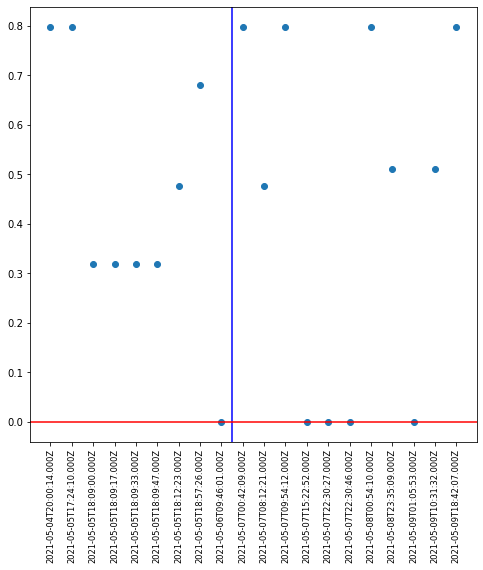

In [228]:
fig, ax1 = plt.subplots(figsize = (8,8))
ax1.scatter(shadow_pages['created_at'], shadow_pages['compound'])
ax1.invert_xaxis()
plt.xticks(rotation=90, fontsize = 'small')
plt.axvline(x=10.5, color='b', label='axvline - full height')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

###### Determining an average sentiment score for Tweets mentioning IAMTHESHADOW.

In [229]:
avg = sum(shadow_pages['compound'])/len(shadow_pages['compound'])
print("The average compound sentiment for IAMTHESHADOW is ", round(avg,2))

The average compound sentiment for IAMTHESHADOW is  0.44


###### The second artist is British gothic rock band Byronic Sex & Exile.

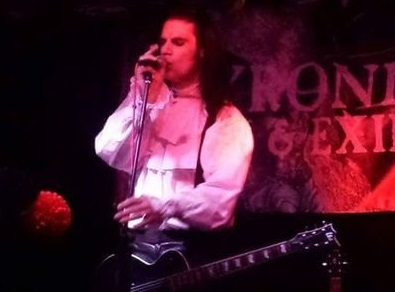

###### Byronic Sex & Exile have 293 Twitter followers and released the full-length album "Yorkshire Gothic" on May 7.

###### Following the same procedure as before, creating a URL and query.

In [230]:
def create_byronic_url():
    query = urllib.parse.quote('("Byronic Sex") OR @byronicsexexile')
    tweet_fields = 'tweet.fields=author_id,public_metrics,id,text,created_at'
    url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
    return url

print(create_byronic_url())

https://api.twitter.com/2/tweets/search/recent?query=%28%22Byronic%20Sex%22%29%20OR%20%40byronicsexexile&tweet.fields=author_id,public_metrics,id,text,created_at


In [231]:
def main2():
    bearer_token = auth()
    url = create_byronic_url()
    headers = create_headers(bearer_token)
    json_response = connect_to_endpoint(url, headers)    
    return json_response

###### Checking retrevied data for accuracy.

In [233]:
main2()

200


{'data': [{'public_metrics': {'retweet_count': 0,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'created_at': '2021-05-09T09:49:08.000Z',
   'author_id': '168487776',
   'id': '1391329380257996801',
   'text': '#nowplaying Byronic Sex and Exile - Timisoara Eyes Byronic https://t.co/eB7Q8oZeSu #goth #gothic #radio'},
  {'public_metrics': {'retweet_count': 0,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'created_at': '2021-05-08T14:49:06.000Z',
   'author_id': '168487776',
   'id': '1391042481488375809',
   'text': '#nowplaying Byronic Sex and Exile - Timisoara Eyes Byronic https://t.co/eB7Q8oZeSu #goth #gothic #radio'},
  {'public_metrics': {'retweet_count': 3,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'created_at': '2021-05-07T12:16:23.000Z',
   'author_id': '453858323',
   'id': '1390641660896423938',
   'text': "RT @byronicsexexile: 'YORKSHIRE GOTHIC': OUT NOW! Delighted to announce that a new Byronic Sex &amp;

In [234]:
byronic_data = main2()

200


In [235]:
byronic_data['data'][2]

{'id': '1390641660896423938',
 'public_metrics': {'retweet_count': 3,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'created_at': '2021-05-07T12:16:23.000Z',
 'text': "RT @byronicsexexile: 'YORKSHIRE GOTHIC': OUT NOW! Delighted to announce that a new Byronic Sex &amp; Exile mini-album 'Yorkshire Gothic' is now…",
 'author_id': '453858323'}

###### Setting up pagination.

In [236]:
def create_url_byronic(next_token = None):
    query = urllib.parse.quote('("Byronic Sex") OR @byronicsexexile')
    tweet_fields = 'tweet.fields=author_id,public_metrics,id,text,created_at'
    if (next_token):        
        pagination = next_token
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&next_token={}&{}'.format(query, pagination, tweet_fields)
        return url
    else:
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
        return url
    
print(create_url_byronic(None))
print(create_url_byronic('000000000000000'))

https://api.twitter.com/2/tweets/search/recent?query=%28%22Byronic%20Sex%22%29%20OR%20%40byronicsexexile&tweet.fields=author_id,public_metrics,id,text,created_at
https://api.twitter.com/2/tweets/search/recent?query=%28%22Byronic%20Sex%22%29%20OR%20%40byronicsexexile&next_token=000000000000000&tweet.fields=author_id,public_metrics,id,text,created_at


In [237]:
def byronic_pages():
    count = 0
    next_token = None
    dat = pd.DataFrame()
    while (count < 1):
        bearer_token = auth()
        url = create_url_byronic(next_token)        
        headers = create_headers(bearer_token)
        json_response = connect_to_endpoint(url, headers)        
        next_token = json_response['meta']['next_token']
        dat = dat.append(pd.DataFrame(json_response['data']), ignore_index = True)        
        count = count + 1
    return dat

In [238]:
byronic_pages = byronic_pages()

200


In [244]:
#byronic_pages

###### Implementing VADER analysis.

In [240]:
byronic_pages['vader_scores'] = [analyser.polarity_scores(x) for x in byronic_pages['text']]
byronic_pages['vader_scores'].head(20)

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...
3    {'neg': 0.201, 'neu': 0.799, 'pos': 0.0, 'comp...
4    {'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...
5    {'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...
6    {'neg': 0.0, 'neu': 0.919, 'pos': 0.081, 'comp...
7    {'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'comp...
8    {'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...
9    {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...
Name: vader_scores, dtype: object

In [241]:
byronic_pages['compound'] = [x['compound'] for x in byronic_pages['vader_scores']]
byronic_pages['compound']

0    0.0000
1    0.0000
2    0.5562
3   -0.8074
4    0.5562
5    0.5562
6    0.5972
7    0.4926
8    0.4753
9    0.5972
Name: compound, dtype: float64

###### Graphing results.

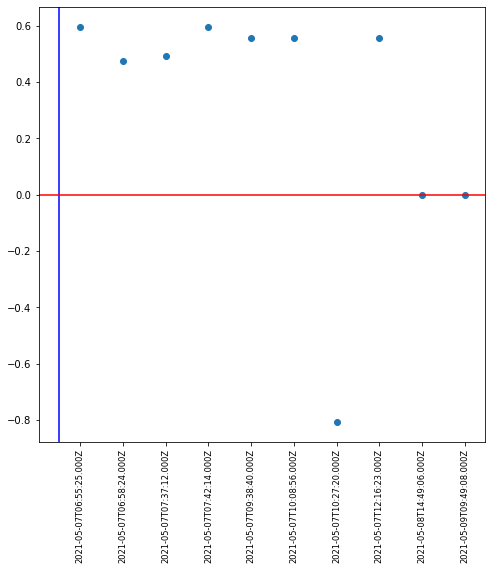

In [242]:
fig, ax1 = plt.subplots(figsize = (8,8))
ax = plt.gca()
ax1.scatter(byronic_pages['created_at'], byronic_pages['compound'])
ax1.invert_xaxis()
plt.xticks(rotation=90, fontsize = 'small')
plt.axvline(x=9.5, color='b', label='axvline - full height')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

###### And finally, determining an average sentiment.

In [243]:
avg2 = sum(byronic_pages['compound'])/len(byronic_pages['compound'])
print("The average compound sentiment for Byronic Sex & Exile is ", round(avg2,2))

The average compound sentiment for Byronic Sex & Exile is  0.3


###### Moving onto the two more popular artists, we consider Irish post-rock artist God is an Astronaut.

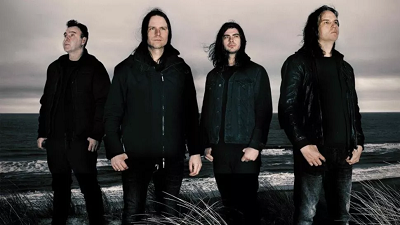

###### God is an Astronaut has 10,000 Twitter followers and released the live album "All is Violent, All is Bright" on May 7.

###### Define the query and build the URL.

In [245]:
def create_astro_url():
    query = urllib.parse.quote('("God Is An Astronaut") OR @Giaa_band')
    tweet_fields = 'tweet.fields=author_id,public_metrics,id,text,created_at'
    url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
    return url

print(create_astro_url())

https://api.twitter.com/2/tweets/search/recent?query=%28%22God%20Is%20An%20Astronaut%22%29%20OR%20%40Giaa_band&tweet.fields=author_id,public_metrics,id,text,created_at


In [151]:
def main3():
    bearer_token = auth()
    url = create_astro_url()
    headers = create_headers(bearer_token)
    json_response = connect_to_endpoint(url, headers)    
    return json_response

In [152]:
main3()

200


{'data': [{'text': '@talldanhegarty @RTE2fm @pagep195 @tanyasweeney @fanningrte @postpunkrunner @jennyhuston @OlanMcGowan @Giaa_band @WhippingBoyBand @DavidBellFirebr @johnmeaghermuso @RTE_Culture @RTE_Ents Babies, sex, &amp; flagons, shifting women, c"mon Bohs.🔴⚫',
   'created_at': '2021-05-09T22:09:51.000Z',
   'public_metrics': {'retweet_count': 0,
    'reply_count': 0,
    'like_count': 3,
    'quote_count': 0},
   'author_id': '1651260738',
   'id': '1391515788679471110'},
  {'text': 'RT @talldanhegarty: 🎧 When We Were Young: The Story of Heartworm ➡️ @RTE2fm at 10pm on Sunday, May 9 featuring interviews with @pagep195, @…',
   'created_at': '2021-05-09T21:13:53.000Z',
   'public_metrics': {'retweet_count': 32,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'author_id': '272719164',
   'id': '1391501703015501824'},
  {'text': 'RT @talldanhegarty: 🎧 When We Were Young: The Story of Heartworm ➡️ @RTE2fm at 10pm on Sunday, May 9 featuring interviews with @pagep1

In [153]:
astro_data = main3()

200


###### Implement pagination.

In [246]:
def create_url_astro(next_token = None):
    query = urllib.parse.quote('("God Is An Astronaut") OR @Giaa_band')
    tweet_fields = 'tweet.fields=author_id,public_metrics,id,text,created_at'
    if (next_token):        
        pagination = next_token
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&next_token={}&{}'.format(query, pagination, tweet_fields)
        return url
    else:
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
        return url
    
print(create_url_astro(None))
print(create_url_astro('000000000000000'))

https://api.twitter.com/2/tweets/search/recent?query=%28%22God%20Is%20An%20Astronaut%22%29%20OR%20%40Giaa_band&tweet.fields=author_id,public_metrics,id,text,created_at
https://api.twitter.com/2/tweets/search/recent?query=%28%22God%20Is%20An%20Astronaut%22%29%20OR%20%40Giaa_band&next_token=000000000000000&tweet.fields=author_id,public_metrics,id,text,created_at


In [159]:
def astro_pages():
    count = 0
    next_token = None
    dat = pd.DataFrame()
    while (count < 14):
        bearer_token = auth()
        url = create_url_astro(next_token)        
        headers = create_headers(bearer_token)
        json_response = connect_to_endpoint(url, headers)        
        next_token = json_response['meta']['next_token']
        dat = dat.append(pd.DataFrame(json_response['data']), ignore_index = True)        
        count = count + 1
    return dat

In [160]:
astro_pages = astro_pages()

200
200
200
200
200
200
200
200
200
200
200
200
200
200


###### Analyze results for VADER sentiment.

In [161]:
astro_pages['vader_scores'] = [analyser.polarity_scores(x) for x in astro_pages['text']]
astro_pages['vader_scores'].head(20)

0     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
5     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6     {'neg': 0.0, 'neu': 0.792, 'pos': 0.208, 'comp...
7     {'neg': 0.172, 'neu': 0.672, 'pos': 0.157, 'co...
8     {'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'comp...
9     {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...
10    {'neg': 0.05, 'neu': 0.784, 'pos': 0.166, 'com...
11    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
12    {'neg': 0.0, 'neu': 0.514, 'pos': 0.486, 'comp...
13    {'neg': 0.185, 'neu': 0.645, 'pos': 0.169, 'co...
14    {'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'comp...
15    {'neg': 0.135, 'neu': 0.764, 'pos': 0.101, 'co...
16    {'neg': 0.0, 'neu': 0.77, 'pos': 0.23, 'compou...
17    {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, '

In [162]:
astro_pages['compound'] = [x['compound'] for x in astro_pages['vader_scores']]
astro_pages['compound']

0      0.0000
1      0.0000
2      0.0000
3      0.0000
4      0.0000
        ...  
135    0.1154
136    0.2732
137    0.2732
138    0.0516
139   -0.5267
Name: compound, Length: 140, dtype: float64

###### Graph results.

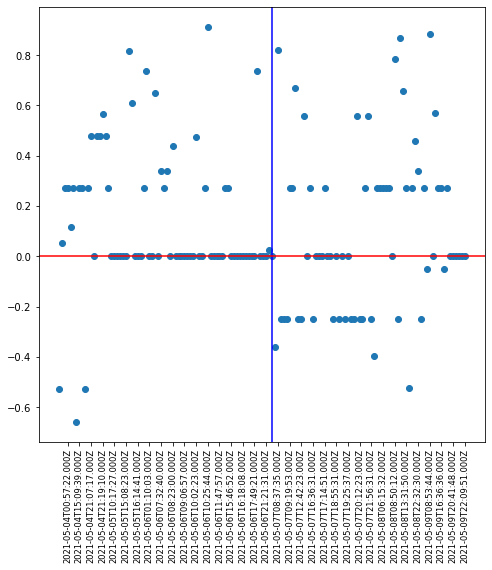

In [168]:
fig, ax1 = plt.subplots(figsize = (8,8))
ax = plt.gca()
ax1.scatter(astro_pages['created_at'], astro_pages['compound'])
ax1.invert_xaxis()
ax.set_xticks(ax.get_xticks()[::4])
plt.xticks(rotation=90, fontsize = 'small')
plt.axvline(x=66, color='b', label='axvline - full height')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

###### Determine average sentiment of Tweets.

In [285]:
avg3 = sum(astro_pages['compound'])/len(astro_pages['compound'])
print("The average for God is an Astronaut is ", round(avg3,2))

The average for God is an Astronaut is  0.12


###### The second of the more popular artists is American singer/songwriter Marissa Nadler.

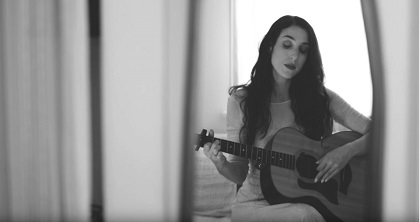

###### Marissa Nadler has 10,200 Twitter followers and released an album of cover songs titled "Instead of Dreaming" on May 7.

###### Once more, create a query and URL.

In [170]:
def create_marissa_url():
    query = urllib.parse.quote('("Marissa Nadler") OR @marissanadler')
    tweet_fields = 'tweet.fields=author_id,public_metrics,id,text,created_at'
    url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
    return url

print(create_marissa_url())

https://api.twitter.com/2/tweets/search/recent?query=%28%22Marissa%20Nadler%22%29%20OR%20%40marissanadler&tweet.fields=author_id,public_metrics,id,text,created_at


In [171]:
def main4():
    bearer_token = auth()
    url = create_marissa_url()
    headers = create_headers(bearer_token)
    json_response = connect_to_endpoint(url, headers)    
    return json_response

In [173]:
main4()

200


{'data': [{'public_metrics': {'retweet_count': 0,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'id': '1391539621222174720',
   'author_id': '3810195853',
   'created_at': '2021-05-09T23:44:33.000Z',
   'text': 'Marissa Nadler - All the Colors of the Dark (Official Video) https://t.co/flnWMz82o2 via @YouTube'},
  {'public_metrics': {'retweet_count': 0,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'id': '1391487222474584079',
   'author_id': '1157336707672477697',
   'created_at': '2021-05-09T20:16:21.000Z',
   'text': 'Marissa Nadler - Instead of Dreaming\n\nhttps://t.co/2VSHwmcAQu\n\n#MarissaNadler  #InsteadofDreaming #folk #folkmusic\n#pop #popmusic'},
  {'public_metrics': {'retweet_count': 1,
    'reply_count': 0,
    'like_count': 0,
    'quote_count': 0},
   'id': '1391482175195815939',
   'author_id': '877022416735657984',
   'created_at': '2021-05-09T19:56:17.000Z',
   'text': 'RT @friday_newmusic: Alt:\nAly &amp; AJ\nAngel Olsen\nA

In [174]:
marissa_data = main4()

200


###### Implement pagination.

In [175]:
def create_url_marissa(next_token = None):
    query = urllib.parse.quote('("Marissa Nadler") OR @marissanadler')
    tweet_fields = 'tweet.fields=author_id,public_metrics,id,text,created_at'
    if (next_token):        
        pagination = next_token
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&next_token={}&{}'.format(query, pagination, tweet_fields)
        return url
    else:
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
        return url
    
print(create_url_marissa(None))
print(create_url_marissa('000000000000000'))

https://api.twitter.com/2/tweets/search/recent?query=%28%22Marissa%20Nadler%22%29%20OR%20%40marissanadler&tweet.fields=author_id,public_metrics,id,text,created_at
https://api.twitter.com/2/tweets/search/recent?query=%28%22Marissa%20Nadler%22%29%20OR%20%40marissanadler&next_token=000000000000000&tweet.fields=author_id,public_metrics,id,text,created_at


In [180]:
def marissa_pages():
    count = 0
    next_token = None
    dat = pd.DataFrame()
    while (count < 17):
        bearer_token = auth()
        url = create_url_marissa(next_token)        
        headers = create_headers(bearer_token)
        json_response = connect_to_endpoint(url, headers)        
        next_token = json_response['meta']['next_token']
        dat = dat.append(pd.DataFrame(json_response['data']), ignore_index = True)        
        count = count + 1
    return dat

In [181]:
marissa_pages = marissa_pages()

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


###### Use VADER to analyse sentiment.

In [182]:
marissa_pages['vader_scores'] = [analyser.polarity_scores(x) for x in marissa_pages['text']]
marissa_pages['vader_scores'].head(20)

0     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3     {'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...
4     {'neg': 0.043, 'neu': 0.898, 'pos': 0.059, 'co...
5     {'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...
6     {'neg': 0.159, 'neu': 0.841, 'pos': 0.0, 'comp...
7     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
8     {'neg': 0.117, 'neu': 0.883, 'pos': 0.0, 'comp...
9     {'neg': 0.0, 'neu': 0.611, 'pos': 0.389, 'comp...
10    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
11    {'neg': 0.174, 'neu': 0.826, 'pos': 0.0, 'comp...
12    {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...
13    {'neg': 0.247, 'neu': 0.753, 'pos': 0.0, 'comp...
14    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
15    {'neg': 0.048, 'neu': 0.842, 'pos': 0.111, 'co...
16    {'neg': 0.061, 'neu': 0.939, 'pos': 0.0, 'comp...
17    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'comp

In [183]:
marissa_pages['compound'] = [x['compound'] for x in marissa_pages['vader_scores']]
marissa_pages['compound']

0      0.0000
1      0.0000
2      0.0000
3      0.3612
4      0.2023
        ...  
164    0.2023
165    0.0000
166   -0.7506
167    0.8399
168    0.2023
Name: compound, Length: 169, dtype: float64

###### Graph the results.

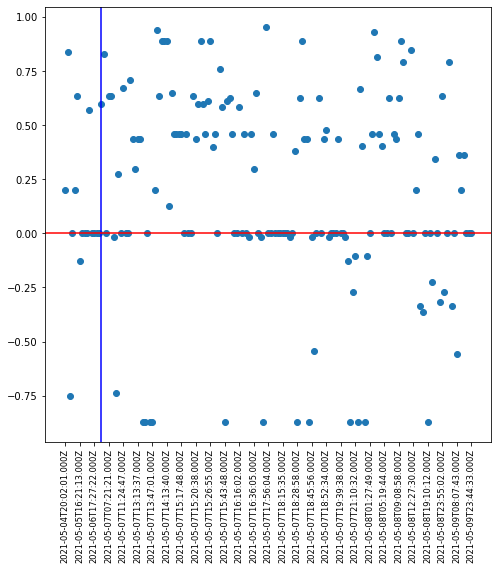

In [190]:
fig, ax1 = plt.subplots(figsize = (8,8))
ax = plt.gca()
ax1.scatter(marissa_pages['created_at'], marissa_pages['compound'])
ax1.invert_xaxis()
ax.set_xticks(ax.get_xticks()[::6])
plt.xticks(rotation=90, fontsize = 'small')
plt.axvline(x=153, color='b', label='axvline - full height')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

###### Determine the average sentiment.

In [286]:
avg4 = sum(marissa_pages['compound'])/len(marissa_pages['compound'])
print("The average for Marissa Nadler is ", round(avg4,2))

The average for Marissa Nadler is  0.18


###### Graphing the VADER sentiment in terms of the number of Twitter followers produces this interesting result.

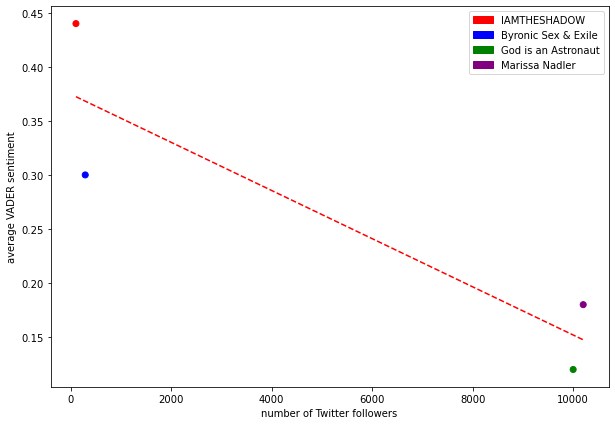

In [279]:
plt.figure(figsize=(10,7))
x = np.array([108,293,10000,10200])
y = np.array([.44,.30,.12,.18])
colors = np.array(["red","blue","green","purple"])
plt.scatter(x, y, c=colors)
plt.xlabel("number of Twitter followers")
plt.ylabel("average VADER sentiment")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
red_patch = mpatches.Patch(color='red', label='IAMTHESHADOW')
blue_patch = mpatches.Patch(color='blue', label='Byronic Sex & Exile')
green_patch = mpatches.Patch(color='green', label='God is an Astronaut')
purple_patch = mpatches.Patch(color='purple', label='Marissa Nadler')
plt.legend(handles=[red_patch, blue_patch, green_patch, purple_patch])
plt.show()

###### The data obviously suffer from a small sample size, but within this limited data there emerges a clear correlation between having more Twitter followers and a lower average VADER sentiment score.  

Considering the other factors from the beginning of this study, there aren't many other correlations that can be drawn. 

Looking at each musician's individual scatterplots from above, two artists (IAMTHESHADOW and God is an Astronaut) seemed to have some existing Twitter conversation before Bandcamp Friday, where the other two (Marissa Nadler and Byronic Sex & Exile) both had very few (or no) Twitter mentions in the days leading up to their respective new releases.  

No correlations can be drawn there, however: IAMTHESHADOW and Marissa Nadler are the two artists who overperformed the VADER sentiment trend line; one of these artists had early hype and one did not.  This tells us that a Bandcamp Friday release can indeed create a "bump" in awareness for a band, but that "bump" doesn't necessarily translate into highly positive sentiment.

Further, one obscure artist and one popular artist overperformed versus the sentiment trend line, while one obscure and one popular artist underperformed.  The overperforming niche artist is less-followed than the underperforming niche artist; for the popular artists, this is reversed as well.  This also tells us that if a Bandcamp Friday "bump" occurs, it's not more likely to benefit bands of a certain popularity level over another.

##### Further hypotheses:

Obscure and niche genre artists would have a strong tendency to congregate towards the left-hand side of this scatter graph, as they are less popular by design & intent. 

This graph may be indicating that fans of niche genres may generally be more positive about new releases; they may just be happy to have something new to listen to at all.  Meanwhile, fans of popular music have many more options and as such may feel more empowered to be critical of new releases.

Having spent many years as a niche-genre-person myself, I'm not sure I buy this interpretation.  Anecdotally, I've personally heard many people be deeply critical of all kinds of new releases from established niche artists; the fans of these kinds of music can sometimes be idealistic to a fault.

Another theory to explain this descending trend line could be that it's just the nature of Twitter.  Pew studies have provided statistical evidence that Twitter conversation is more negative than off-Twitter conversation in general(1), and it's colloquial knowledge that negative content often performs better with social media algorithms.  

Given this, it seems possible that greater popularity on Twitter may naturally result in a lower average VADER sentiment, simply by virtue of being popular on Twitter.  Looking at the scatter graphs of both of the more popular artists exposes what seems to be one particularly negative Tweet that took hold, got a number of retweets, and dragged down the artist's averages(2,3), whereas the niche bands don't show a similar pattern.

(1) https://observer.com/2013/03/pew-study-confirms-twitter-is-dominated-by-negative-assholes/

(2) God is an Astronaut's negative "streak":

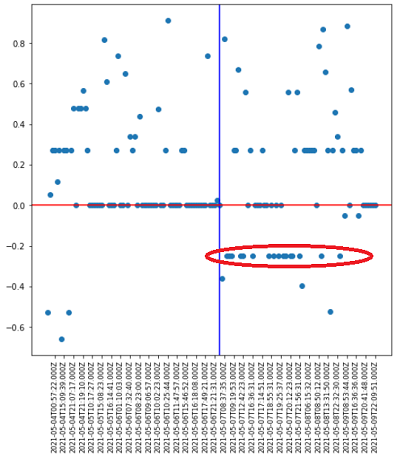

(3) Marissa Nadler's negative "streak":

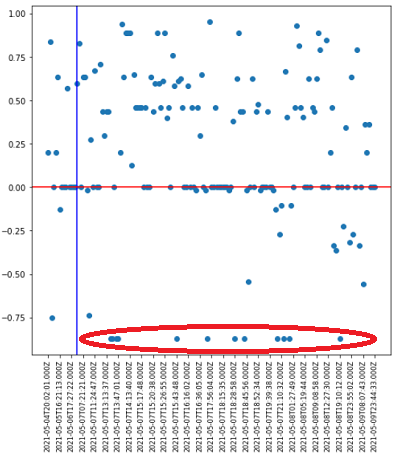

###### In conclusion:

I would be incredibly interested just to collect more data points to see if the pattern holds.  I also wonder if the downward pattern would continue into negative average sentiment territory with mega-popular superstar artists, or if there may be an inflection point where an artist becomes popular enough to overcome the inherent Twitter negativity, and sentiment starts trending upwards.  I did attempt to find a data point at this end of the popularity spectrum, but no household-name-level artists released a Bandcamp Friday album (that I was aware of), and even without a Bandcamp Friday release, searching for mentions of "Demi Lovato" burned up half of my monthly Tweet allowance in a big hurry.

Finally, Tweets and VADER sentiment and anything else capturable through this data are interesting and potentially useful, but don't necessarily equate to album sales.  That would be an interesting additional data point to wrangle and try to find correlation with Twitter sentiment, hype, or popularity.